In [ ]:
# pip install numpy
# pip install opencv-python
# pip install scikit-image
# pip install scikit-learn
# pip install matplotlib
# pip install seaborn

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Function to load images from folder, picking 1000 random images from each class
def load_images_from_folder(folder, num_images_per_class=1200):
    images = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if not os.path.isdir(class_folder):
            print(f"Skipping non-directory item: {class_folder}")
            continue
        all_images = os.listdir(class_folder)
        if len(all_images) < num_images_per_class:
            print(f"Not enough images in {class_folder}. Found {len(all_images)}, required {num_images_per_class}")
            continue
        selected_images = random.sample(all_images, num_images_per_class)
        for filename in selected_images:
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            img = cv2.resize(img, (256, 256))  # Resizing images to a consistent size 
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [3]:
# Loading images and labels
folder = 'D:\AAI_project\COMP-6721-Project\data' 
images, labels = load_images_from_folder(folder)
print(f"Loaded {len(images)} images with {len(labels)} labels.")
print(f"Unique labels found: {set(labels)}")

Loaded 6000 images with 6000 labels.
Unique labels found: {'subway_station', 'bar', 'hospital_room', 'gymnasium', 'restaurant'}


In [4]:
# Function to extract color histograms
def extract_color_histograms(images):
    histograms = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)
    return np.array(histograms)

In [5]:
def extract_lbp_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)


In [6]:
# Extracting color histograms
X_color_hist = extract_color_histograms(images)

# Extract LBP features
X_lbp = extract_lbp_features(images)

# Flatten images for the classifier
images_flattened = images.reshape((images.shape[0], -1))

In [7]:
# Concatenate features with flattened pixel values
X_combined = np.concatenate((images_flattened, X_color_hist, X_lbp), axis=1)

In [8]:
# Split the data into labeled and unlabeled sets
X_train,X_temp, y_train, y_temp= train_test_split(X_combined, labels, test_size=0.2, random_state=42, stratify=labels)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
x_test,X_val, y_test, y_val= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



In [ ]:
len(X_labeled)

960

In [9]:
from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(random_state=42,max_depth=10)
clf = DecisionTreeClassifier(max_depth=7, random_state=42)
clf.fit(X_labeled, y_labeled)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [10]:
# Function to process the unlabeled data in batches
def process_unlabeled_in_batches(clf, X_unlabeled, batch_size=500):
    num_samples = X_unlabeled.shape[0]
    y_unlabeled_pred = np.zeros(num_samples, dtype=str)
    probas = np.zeros((num_samples, clf.n_classes_), dtype=float)

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        X_batch = X_unlabeled[start:end]
        y_unlabeled_pred[start:end] = clf.predict(X_batch)
        probas[start:end] = clf.predict_proba(X_batch)

    return y_unlabeled_pred, probas



def process_unlabeled(clf, X_unlabeled):
    y_unlabeled_pred = clf.predict(X_unlabeled)
    probas = clf.predict_proba(X_unlabeled)
    return y_unlabeled_pred, probas


def collect_high_confidence_samples(X_unlabeled, y_unlabeled_pred, probas, prob_threshold=0.7):
    print("Collecting high-confidence samples")
    high_confidence_indices = np.where(np.max(probas, axis=1) > prob_threshold)[0]

    if len(high_confidence_indices) > 0:
        X_high_conf = X_unlabeled[high_confidence_indices]
        y_high_conf = y_unlabeled_pred[high_confidence_indices]
    else:
        X_high_conf = np.array([])
        y_high_conf = np.array([])

    return X_high_conf, y_high_conf, high_confidence_indices


# Pseudo-labeling and iterative training
for iteration in range(10):  
    # Process the unlabeled data in batches
    y_unlabeled_pred, probas = process_unlabeled(clf, X_unlabeled)
    
    # Collect high-confidence samples
    X_high_conf, y_high_conf, high_confidence_indices = collect_high_confidence_samples(X_unlabeled, y_unlabeled_pred, probas)


    if len(high_confidence_indices) == 0:
        print(f"Iteration {iteration + 1}: No high-confidence samples found. Stopping iteration.")
        break


    if X_high_conf.size == 0:
        print(f"Iteration {iteration + 1}: No samples passed the threshold. Stopping iteration.")
        break

    # Calculate and print the accuracy of the high-confidence samples
    high_confidence_accuracy = accuracy_score(y_unlabeled[high_confidence_indices], y_high_conf)
    print("\n")
    print(f"Iteration {iteration + 1}")
    print(f"High-confidence samples accuracy = {high_confidence_accuracy:.4f}")


    # Update the labeled dataset
    X_labeled = np.vstack((X_labeled, X_high_conf))
    y_labeled = np.hstack((y_labeled, y_high_conf))

    # Remove the high-confidence samples from the unlabeled set
    X_unlabeled = np.delete(X_unlabeled, high_confidence_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, high_confidence_indices, axis=0)

    # Retrain the model with the updated labeled dataset
    clf.fit(X_labeled, y_labeled)

    # Evaluate the model after retraining
    y_val_pred = clf.predict(X_val)
    validation_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation data accuracy = {validation_accuracy:.4f}")

    if X_unlabeled.size == 0:
        print("No more unlabeled data left.")
        break
    print("-----------------------------")



Iteration 1
High-confidence samples accuracy = 0.3814
Validation data accuracy = 0.3700
-----------------------------


Iteration 2
High-confidence samples accuracy = 0.2662
Validation data accuracy = 0.3567
-----------------------------


Iteration 3
High-confidence samples accuracy = 0.1667
Validation data accuracy = 0.3683
-----------------------------


Iteration 4
High-confidence samples accuracy = 0.8333
Validation data accuracy = 0.3700
-----------------------------
Iteration 5: No high-confidence samples found. Stopping iteration.


In [11]:
# Predicting and evaluating the final Decision Tree classifier
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [12]:
# Classification report and metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 36.50%
Precision: 37.23%
Recall: 36.50%
F1 Score: 36.22%

Classification Report:
                 precision    recall  f1-score   support

           bar       0.44      0.30      0.36       120
     gymnasium       0.38      0.42      0.40       120
 hospital_room       0.33      0.48      0.39       120
    restaurant       0.38      0.34      0.36       120
subway_station       0.34      0.28      0.31       120

      accuracy                           0.36       600
     macro avg       0.37      0.36      0.36       600
  weighted avg       0.37      0.36      0.36       600



In [13]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[36 14 20 24 26]
 [ 4 50 45 14  7]
 [ 6 32 58 11 13]
 [23 17 19 41 20]
 [13 19 35 19 34]]


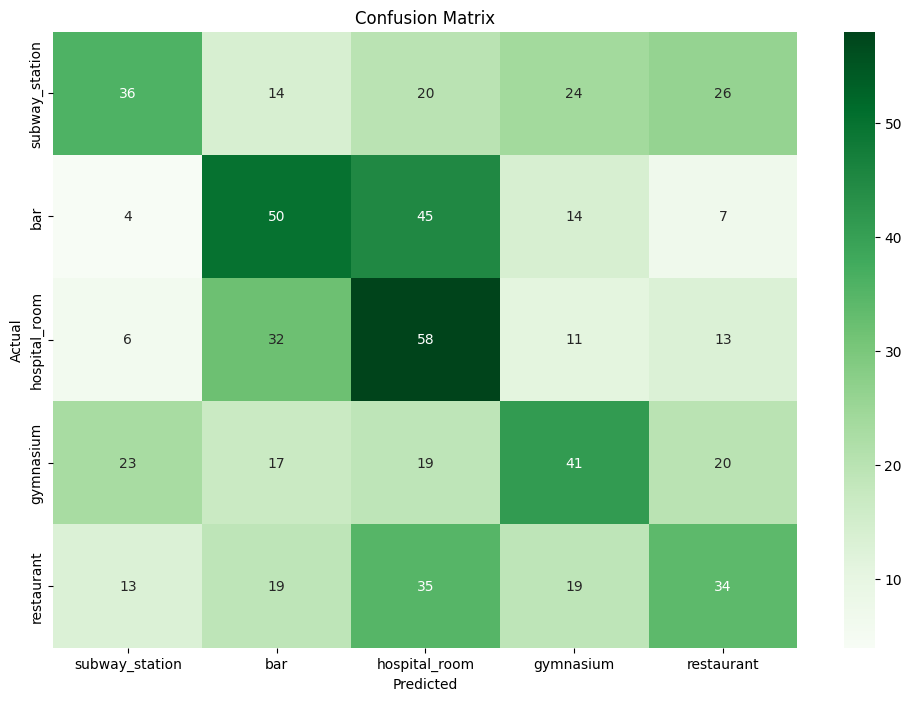

In [14]:
# Plotting the Confusion Matrix for our Decision Tree Model
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=set(labels), yticklabels=set(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Saving the semi-supervised decision tree model
model_path = 'adjusted_semi_supervised_decision_tree_model.joblib' 
joblib.dump(clf, model_path)
print(f'Model saved to {model_path}')

Model saved to adjusted_semi_supervised_decision_tree_model.joblib


In [18]:


# Load the saved decision tree model
dt_model = joblib.load('adjusted_semi_supervised_decision_tree_model.joblib')

# Analyze the decision tree model
num_leaves = dt_model.get_n_leaves()
tree_depth = dt_model.get_depth()

print(f"Number of leaves: {num_leaves}")
print(f"Tree depth: {tree_depth}")


Number of leaves: 114
Tree depth: 7
